In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [2]:
df = pd.read_csv("prepped_churn_data.csv")

df.index = range(1, len(df) + 1)

df.insert(0, "customerID", df.index)

df.head(5)

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_TotalCharges_Ratio
1,1,1,0,Month-to-month,Electronic check,29.85,29.85,0,1.000000
2,2,34,1,One year,Mailed check,56.95,1889.50,0,0.030140
3,3,2,1,Month-to-month,Mailed check,53.85,108.15,1,0.497920
4,4,45,0,One year,Bank transfer (automatic),42.30,1840.75,0,0.022980
5,5,2,1,Month-to-month,Electronic check,70.70,151.65,1,0.466205


In [3]:
payment_method_dummies = pd.get_dummies(df['PaymentMethod'])
contract_dummies = pd.get_dummies(df['Contract'])

# Combine the dummy variables with the original DataFrame
df = pd.concat([df, payment_method_dummies, contract_dummies], axis=1)
df.head()

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_TotalCharges_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year
1,1,1,0,Month-to-month,Electronic check,29.85,29.85,0,1.000000,False,False,True,False,True,False,False
2,2,34,1,One year,Mailed check,56.95,1889.50,0,0.030140,False,False,False,True,False,True,False
3,3,2,1,Month-to-month,Mailed check,53.85,108.15,1,0.497920,False,False,False,True,True,False,False
4,4,45,0,One year,Bank transfer (automatic),42.30,1840.75,0,0.022980,True,False,False,False,False,True,False
5,5,2,1,Month-to-month,Electronic check,70.70,151.65,1,0.466205,False,False,True,False,True,False,False


## Convert dummies to numeric

In [4]:
categorical_columns = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Month-to-month', 'One year', 'Two year']

for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

df.sample(5)

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_TotalCharges_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year
4498,4498,72,1,Two year,Mailed check,26.00,1776.00,0,0.014640,0,0,1,1,1,0,1
6474,6474,1,1,Month-to-month,Electronic check,101.45,101.45,1,1.000000,0,0,0,0,0,0,0
6462,6462,8,1,One year,Mailed check,43.45,345.50,0,0.125760,0,0,1,1,1,1,0
6426,6426,1,1,Month-to-month,Electronic check,50.50,50.50,1,1.000000,0,0,0,0,0,0,0
11,11,13,1,Month-to-month,Mailed check,49.95,587.45,0,0.085029,0,0,1,1,0,0,0


In [5]:
# Drop the original categorical columns and the customerID column
df.drop(['PaymentMethod', 'Contract', 'customerID'], axis=1, inplace=True)
df.head(5)


,tenure,PhoneService,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_TotalCharges_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year
1,1,0,29.85,29.85,0,1.000000,0,0,0,0,0,0,0
2,34,1,56.95,1889.50,0,0.030140,0,0,1,1,1,1,0
3,2,1,53.85,108.15,1,0.497920,0,0,1,1,0,0,0
4,45,0,42.30,1840.75,0,0.022980,1,0,1,0,1,1,0
5,2,1,70.70,151.65,1,0.466205,0,0,0,0,0,0,0


Now the data is ready for Modelling

## Break data into features and targets

In [6]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## Split data into Training and Test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit a decision tree to the training data

In [8]:
dt_model = DecisionTreeClassifier(max_depth=3)  
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

## Plot the decision tree

In [9]:
tree_rules = export_text(dt_model, feature_names=list(X.columns))
print(tree_rules)

|--- Month-to-month <= 0.50
|   |--- MonthlyCharges <= 67.60
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio <= 0.32
|   |   |   |--- class: 0
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio >  0.32
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  67.60
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio <= 0.08
|   |   |   |--- class: 0
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio >  0.08
|   |   |   |--- class: 1
|--- Month-to-month >  0.50
|   |--- MonthlyCharges <= 93.67
|   |   |--- Two year <= 0.50
|   |   |   |--- class: 0
|   |   |--- Two year >  0.50
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  93.67
|   |   |--- TotalCharges <= 6586.10
|   |   |   |--- class: 0
|   |   |--- TotalCharges >  6586.10
|   |   |   |--- class: 0



**Root Node**

Month-to-month is the first feature used for splitting the data.

If Month-to-month is less than or equal to 0.50, it goes to the left branch; otherwise, it goes to the right branch.

**First Split (Left Branch)**

If Month-to-month is less than or equal to 0.50, it further checks MonthlyCharges.

If MonthlyCharges is less than or equal to 67.60, it checks MonthlyCharges_to_TotalCharges_Ratio.

If MonthlyCharges_to_TotalCharges_Ratio is less than or equal to 0.32, the predicted class is 0.

If MonthlyCharges_to_TotalCharges_Ratio is greater than 0.32, the predicted class is 0.

If MonthlyCharges is greater than 67.60, it checks MonthlyCharges_to_TotalCharges_Ratio.

If MonthlyCharges_to_TotalCharges_Ratio is less than or equal to 0.08, the predicted class is 0.

If MonthlyCharges_to_TotalCharges_Ratio is greater than 0.08, the predicted class is 1.

**Second Split (Right Branch)**

If Month-to-month is greater than 0.50, it checks MonthlyCharges.

If MonthlyCharges is less than or equal to 93.67, it checks One year.

If One year is less than or equal to 0.50, the predicted class is 0.

If One year is greater than 0.50, the predicted class is 0.

If MonthlyCharges is greater than 93.67, it checks TotalCharges.

If TotalCharges is less than or equal to 6586.10, the predicted class is 0.

If TotalCharges is greater than 6586.10, the predicted class is 0.

### Interpretation

**Root Node (Month-to-month**

The first split is based on the contract type, specifically if a customer is on a month-to-month contract or not.

This aligns with business understanding as month-to-month contracts might be more prone to churn due to their shorter commitment.

**First Split (Left Branch - Month-to-month Contract)**

Further decisions are made based on monthly charges and the ratio of monthly charges to total charges.

Lower values of these features are associated with a predicted class of 0 (no churn), indicating that customers with lower charges and a reasonable ratio are less likely to churn.

**First Split (Right Branch - Other Contracts)**

For customers on contracts other than month-to-month, decisions are made based on monthly charges, the duration of the contract (One year), and total charges.

Similar to the left branch, lower values are associated with a predicted class of 0 (no churn).

### Business Insights

The model suggests that customers with longer-term contracts are less likely to churn.

For month-to-month customers, lower monthly charges and a reasonable ratio of monthly charges to total charges indicate lower churn risk.

Higher monthly charges and a higher ratio in month-to-month customers increase the likelihood of churn.

The tree doesn't seem to heavily rely on the features One year and TotalCharges for the non-month-to-month contracts.

## Hyperparameter tuning for decision tree

In [10]:
param_grid = {'max_depth': [3, 5, 7, 10]} 
dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10]})

In [11]:
# Best hyperparameters
best_max_depth = grid_search.best_params_['max_depth']
best_max_depth

5

## Fit a decision tree with the best hyperparameter

In [12]:
dt_model_tuned = DecisionTreeClassifier(max_depth=best_max_depth)
dt_model_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

## Plot the decision tree

In [13]:
tree_rules_tuned = export_text(dt_model_tuned, feature_names=list(X.columns))
print(tree_rules_tuned)

|--- Month-to-month <= 0.50
|   |--- MonthlyCharges <= 67.60
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio <= 0.32
|   |   |   |--- PhoneService <= 0.50
|   |   |   |   |--- TotalCharges <= 352.20
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalCharges >  352.20
|   |   |   |   |   |--- class: 0
|   |   |   |--- PhoneService >  0.50
|   |   |   |   |--- MonthlyCharges_to_TotalCharges_Ratio <= 0.06
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- MonthlyCharges_to_TotalCharges_Ratio >  0.06
|   |   |   |   |   |--- class: 0
|   |   |--- MonthlyCharges_to_TotalCharges_Ratio >  0.32
|   |   |   |--- MonthlyCharges <= 20.88
|   |   |   |   |--- MonthlyCharges_to_TotalCharges_Ratio <= 0.61
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- MonthlyCharges_to_TotalCharges_Ratio >  0.61
|   |   |   |   |   |--- class: 0
|   |   |   |--- MonthlyCharges >  20.88
|   |   |   |   |--- PhoneService <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PhoneService

## Plot correlations between features and targets

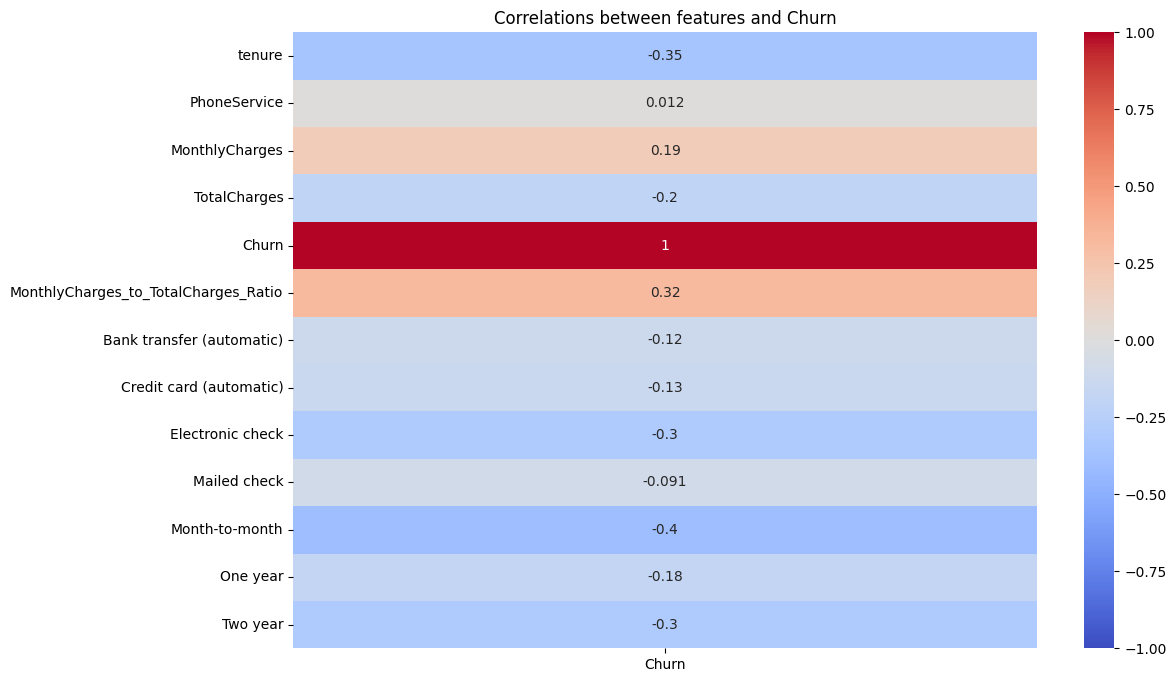

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['Churn']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations between features and Churn")
plt.show()

## Fit a random forest model

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Plot feature importances from the RF

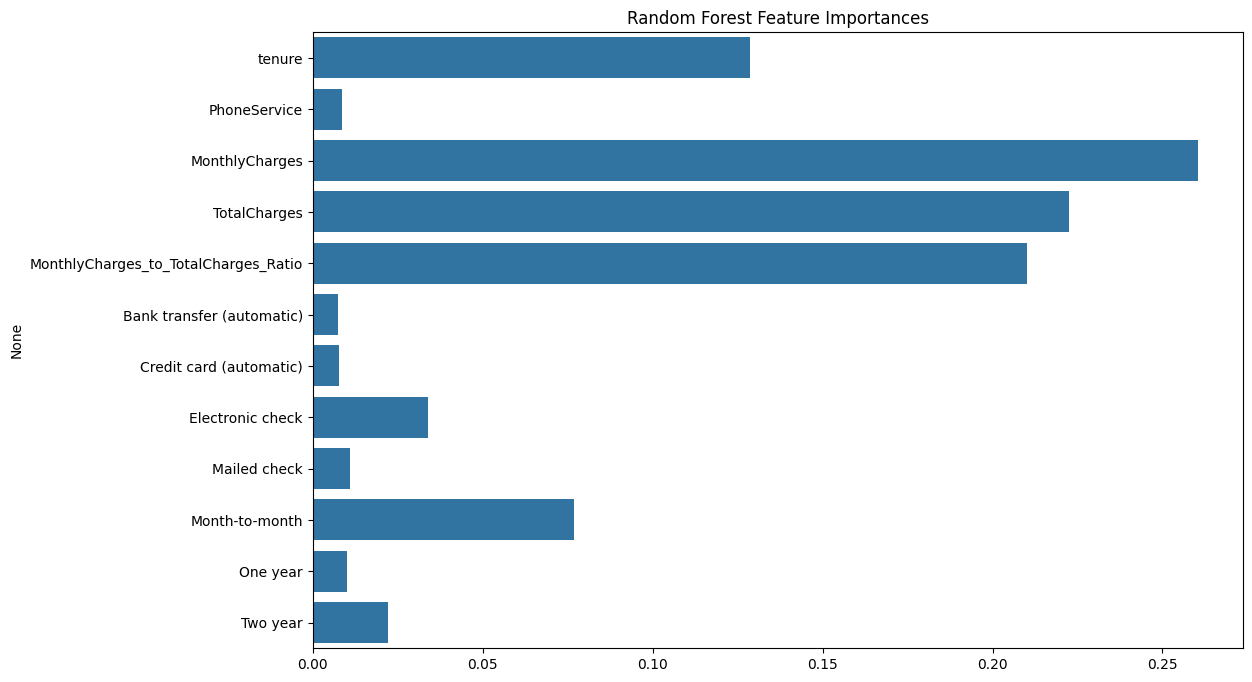

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importances")
plt.show()


## Remove less-important features

In [24]:
less_important_features = ['PhoneService', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Mailed check', 'One year'] 

X_train_filtered = X_train.drop(less_important_features, axis=1)
X_test_filtered = X_test.drop(less_important_features, axis=1)

X_train_filtered.shape

(5625, 7)

## Fit RF to new data

In [18]:
rf_model_filtered = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train)

RandomForestClassifier(random_state=42)

## Plot feature imporatnces

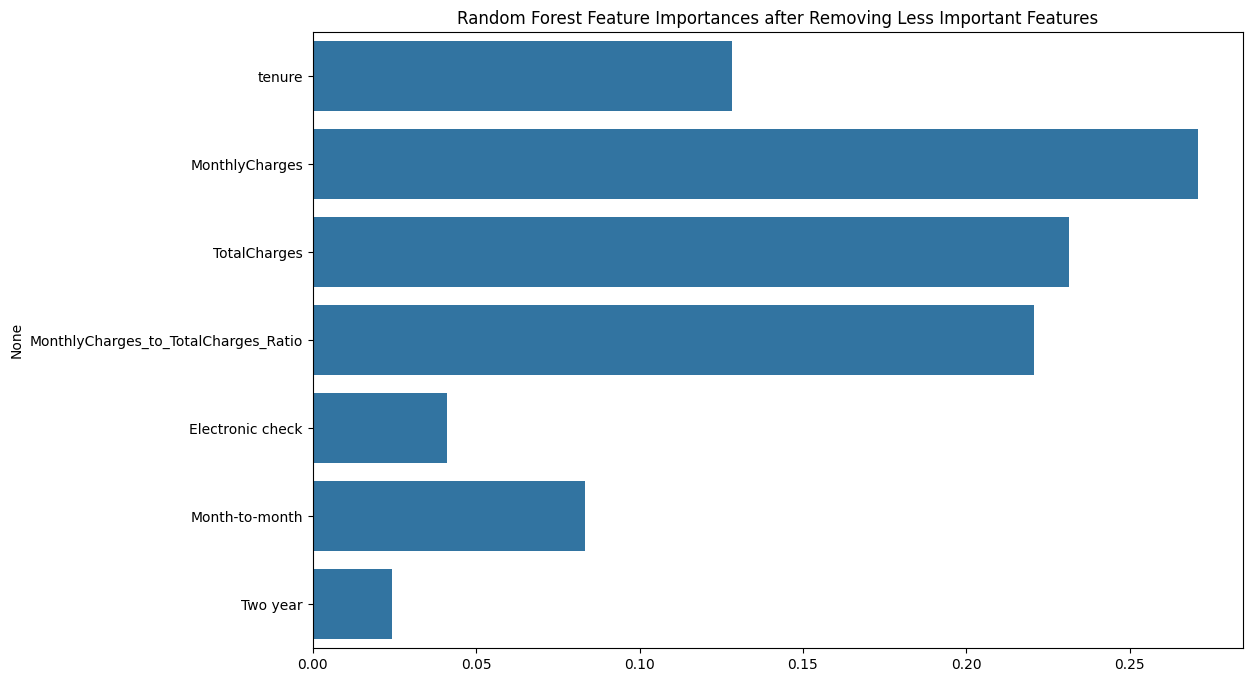

In [19]:
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_model_filtered.feature_importances_, y=X_train_filtered.columns)
plt.title("Random Forest Feature Importances after Removing Less Important Features")
plt.show()


##  Evaluate Model performance

In [20]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## The earlier dt

In [21]:
print("Evaluation of Tuned Decision Tree Model:")
evaluate_model(dt_model_tuned, X_test, y_test)

Evaluation of Tuned Decision Tree Model:
Accuracy: 0.7676, Precision: 0.5732, Recall: 0.4920, F1 Score: 0.5295


## Earlier RF

In [22]:
print("\nEvaluation of Random Forest Model:")
evaluate_model(rf_model, X_test, y_test)



Evaluation of Random Forest Model:
Accuracy: 0.7626, Precision: 0.5667, Recall: 0.4545, F1 Score: 0.5045


## RF with no less important features

In [23]:
print("\nEvaluation of Random Forest Model after Removing Less Important Features:")
evaluate_model(rf_model_filtered, X_test_filtered, y_test)


Evaluation of Random Forest Model after Removing Less Important Features:
Accuracy: 0.7647, Precision: 0.5754, Recall: 0.4385, F1 Score: 0.4977


## Interpretation of the Results

**Tuned Decision Tree vs. Original Random Forest**

The tuned decision tree shows slightly better performance across all metrics compared to the original random forest.

**Random Forest Model with and without Feature Removal**

Removing less important features had a modest impact on the random forest model's performance.
The accuracy and precision slightly improved, but there is a trade-off with a decrease in recall and F1 score.

## Summary of Plots and Interpretation:

**Decision Tree Rules**

The decision tree, especially after tuning, provides a clear set of rules for predicting churn.
Key factors include contract type (month-to-month), monthly charges, and the ratio of monthly charges to total charges.

**Correlation Heatmap**

The heatmap visually represents the correlations between features and the target variable (Churn).
Features with higher absolute correlations are more influential in predicting churn.

**Random Forest Feature Importances**

The bar plot displays feature importances from the random forest model.
Features like 'Month-to-month', 'MonthlyCharges', and 'MonthlyCharges_to_TotalCharges_Ratio' show higher importance.

**Random Forest Feature Importances after Removing Less Important Features**

After removing less important features, the bar plot reflects updated feature importances.
Features like 'Month-to-month' and 'MonthlyCharges' continue to play a significant role.

## Summary

In this analysis, we began by preprocessing the churn data, including the creation of dummy variables for categorical features and factorization of selected columns. We trained decision tree and random forest models, initially evaluating their performance using accuracy, precision, recall, and F1 score metrics. The decision tree model was further refined through hyperparameter tuning using GridSearchCV to optimize the max_depth parameter. Upon identifying less important features, a modified random forest model was created after their removal. In model evaluation, we assessed the tuned decision tree, the original random forest, and the modified random forest, observing moderate accuracy across all models. Notably, the removal of less important features had a modest impact on overall model performance.